# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.192882,True,6.307669
1,-0.697688,False,-2.799823
2,1.683245,True,8.660512
3,2.229438,True,10.030420
4,-1.008652,False,-1.923299
...,...,...,...
995,0.933524,False,3.303752
996,1.204917,True,6.682914
997,2.107063,True,11.898302
998,-0.074520,True,5.089832


<AxesSubplot: xlabel='v0'>

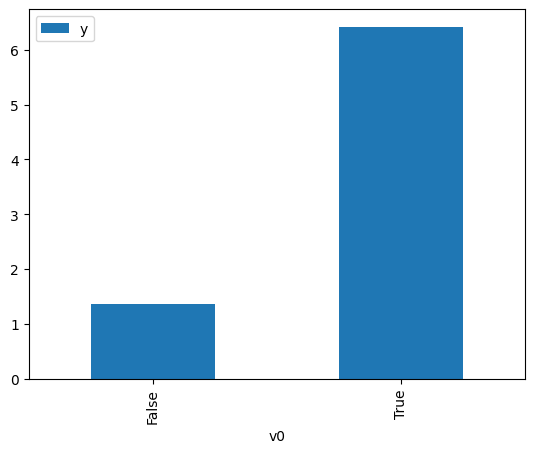

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

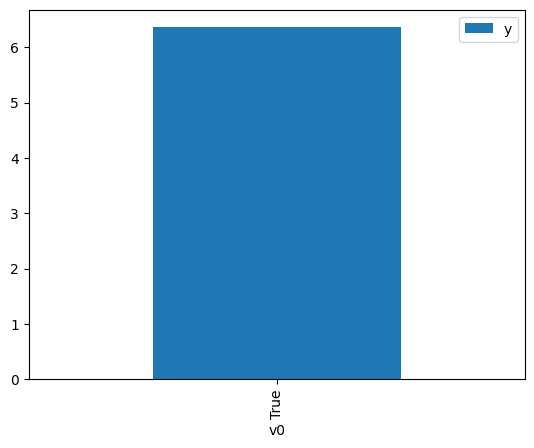

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.206499,False,4.170055,0.056605,17.666343
1,-0.068734,False,-0.269160,0.529259,1.889435
2,-0.475105,False,-1.785903,0.654886,1.526984
3,0.360181,False,1.125425,0.392865,2.545405
4,-0.140223,False,-0.107828,0.552122,1.811194
...,...,...,...,...,...
995,1.484792,False,2.886986,0.131951,7.578547
996,-0.158099,False,-0.788303,0.557808,1.792730
997,0.259793,False,-0.113174,0.424095,2.357960
998,1.253754,False,1.269634,0.169915,5.885300


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.190820,True,3.289733,0.554074,1.804813
1,0.064957,True,5.552145,0.513754,1.946457
2,0.378431,True,6.093418,0.612728,1.632047
3,1.806196,True,8.779261,0.908694,1.100481
4,1.897350,True,9.241507,0.917979,1.089350
...,...,...,...,...,...
995,1.970058,True,7.782058,0.924760,1.081362
996,1.919330,True,8.588470,0.920086,1.086855
997,0.804969,True,8.156917,0.732665,1.364881
998,0.378624,True,5.898987,0.612787,1.631890


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          1.983e+04
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:29:03   Log-Likelihood:                         -1390.2
No. Observations:                1000   AIC:                                      2784.
Df Residuals:                     998   BIC:                                      2794.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4302      0.035     69.138      0.000       2.361       2.499
x2             4.9360      0.051     97.066      0.000       4.836       5.036
==============================================================================
Omnibus:                        1.184   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.553   Jarque-Bera (JB):                1.232
Skew:                          -0.043   Prob(JB):                        0.540
Kurtosis:                       2.851   Cond. No.                         2.39
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""